# 迴歸(Regression)與時間序列(Time Series) 比較

## 載入相關套件

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

## 載入資料集

In [2]:
df = pd.read_csv("./data/monthly-airline-passengers.csv")
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


## 資料轉換

In [3]:
# 設定為日期的資料型態
df["Date"] = pd.to_datetime(df["Month"])

# 設定日期為 DataFrame 的索引值
df = df.set_index("Date")

# 依照資料內容設定日期的頻率
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
# 將原有欄位刪除
df.drop("Month", axis=1, inplace=True)

## 繪圖

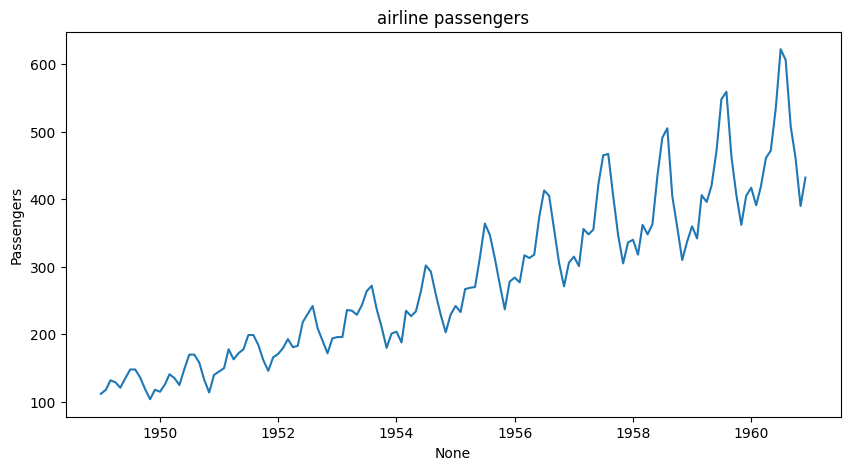

In [4]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y="Passengers", data=df)
plt.title("airline passengers")

## 迴歸(Regression)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lr = LinearRegression()
# X = df.index.astype(str).map(lambda x:x[:4]+x[5:7]).values.reshape(df.shape[0], -1)
X = np.arange(df.shape[0]).reshape(-1, 1)
y = df["Passengers"]
lr.fit(X, y)
pred = lr.predict(X)
print("MSE =", mean_squared_error(y, pred))

MSE = 2091.7994339346533


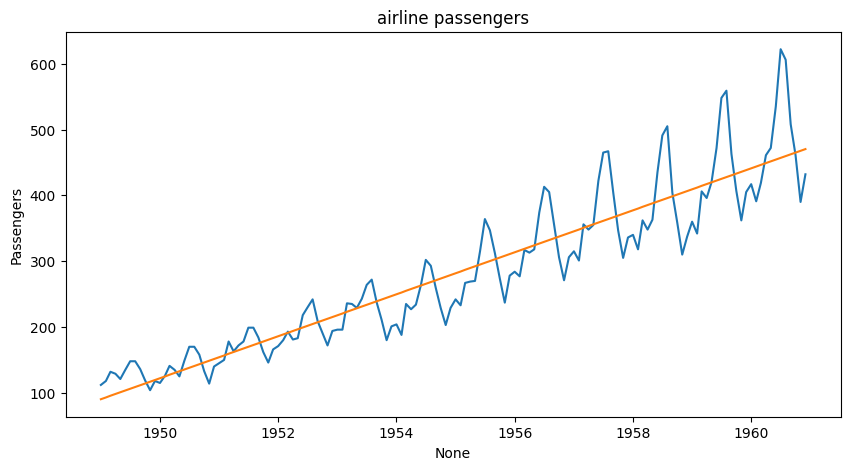

In [6]:
# 實際樣本點
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y="Passengers", data=df)
plt.title("airline passengers")

# 預測迴歸線
plt.plot(df.index, pred);

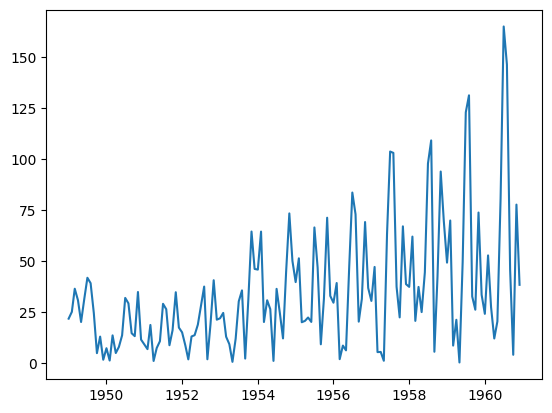

In [7]:
# 殘差線圖
plt.plot(df.index, np.abs(df["Passengers"] - pred));

## 定態測試(Augmented Dickey–Fuller Test for Stationarity)

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Passengers"])
print(
    f"ADF統計量: {result[0]}\np value: {result[1]}"
    + f"\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}"
)

ADF統計量: 0.8153688792060539
p value: 0.9918802434376411
滯後期數(Lags): 13
資料筆數: 130


## 結論：p > 0.05 ==> 非定態

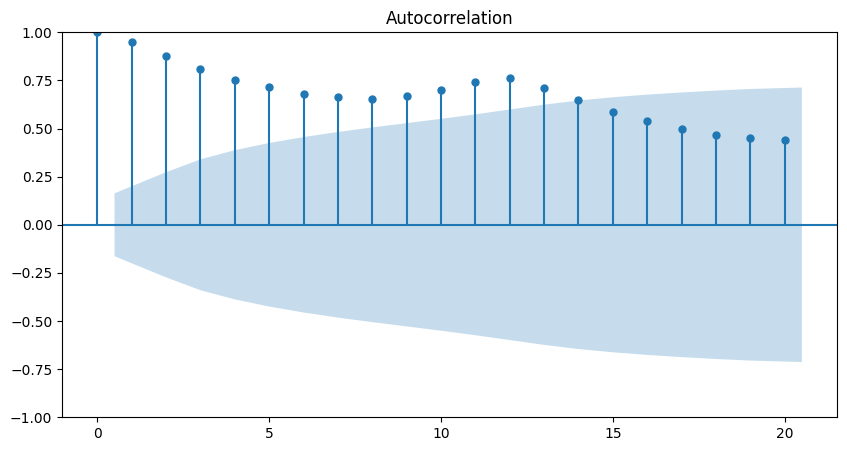

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(df["Passengers"], lags=20)
fig.set_size_inches(10, 5)

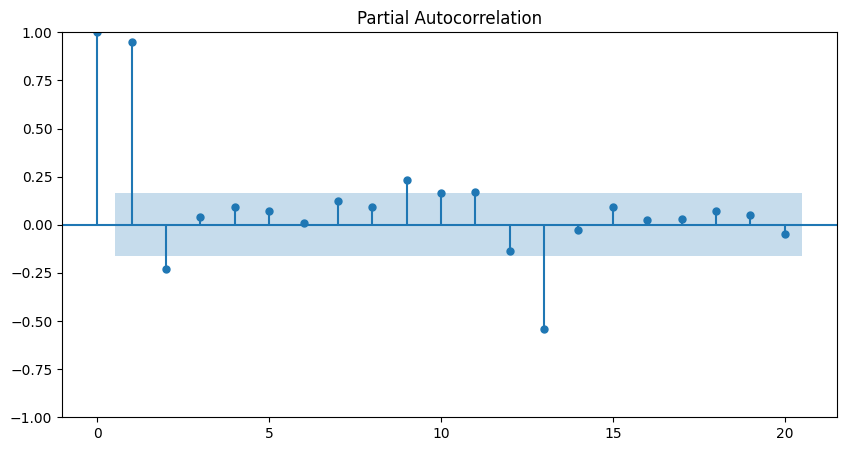

In [10]:
fig = plot_pacf(df["Passengers"], lags=20, method="ywm")
fig.set_size_inches(10, 5)

## 時間序列(Time Series)

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# 建立時間序列資料
series = df.copy()

# AR(1) 模型訓練
ar = ARIMA(df, order=(1, 0, 0))
model = ar.fit()

# 顯示模型訓練報告
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -711.090
Date:                Thu, 05 Sep 2024   AIC                           1428.181
Time:                        20:23:46   BIC                           1437.090
Sample:                    01-01-1949   HQIC                          1431.801
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.2943     66.403      4.221      0.000     150.146     410.442
ar.L1          0.9645      0.019     51.535      0.000       0.928       1.001
sigma2      1118.5409    122.133      9.158      0.0

In [12]:
model.params

const      280.294340
ar.L1        0.964549
sigma2    1118.540874
dtype: float64

In [13]:
df["Passengers"].mean()

280.2986111111111

## 繪圖比較實際值與預測值

In [14]:
model.fittedvalues

1949-01-01    280.294340
1949-02-01    117.966280
1949-03-01    123.753571
1949-04-01    137.257251
1949-05-01    134.363605
                 ...    
1960-08-01    609.886036
1960-09-01    594.453259
1960-10-01    499.927502
1960-11-01    454.593721
1960-12-01    386.110774
Freq: MS, Length: 144, dtype: float64

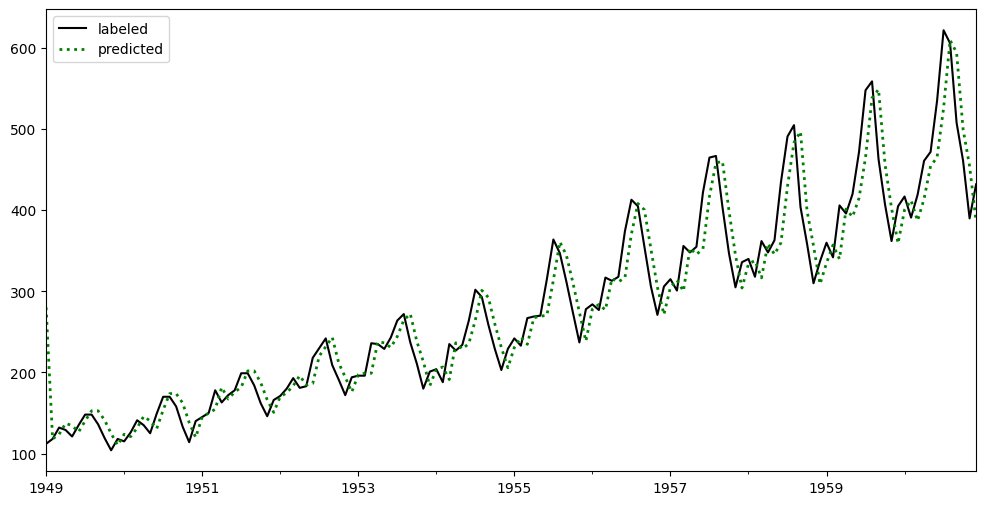

In [15]:
series["Passengers"].plot(figsize=(12, 6), color="black", linestyle="-", label="labeled")
model.fittedvalues.plot(
    figsize=(12, 6), color="green", linestyle=":", lw=2, label="predicted"
)
plt.legend()

In [16]:
print(f"AR MSE = {(np.sum(model.resid**2) / len(model.resid)):.2f}")

AR MSE = 1301.63


## 使用迴歸驗證

In [17]:
lr2 = LinearRegression()

# 複製資料
series2 = series.copy()

# 將前一期 y 當作 x
series2["Passengers_1"] = series2["Passengers"].shift(-1)
series2.dropna(inplace=True)
X = series2["Passengers"].values.reshape(series2.shape[0], -1)

# 模型訓練
lr2.fit(X, series2["Passengers_1"])
lr2.coef_, lr2.intercept_

(array([0.95893198]), 13.705504997522155)

<Axes: >

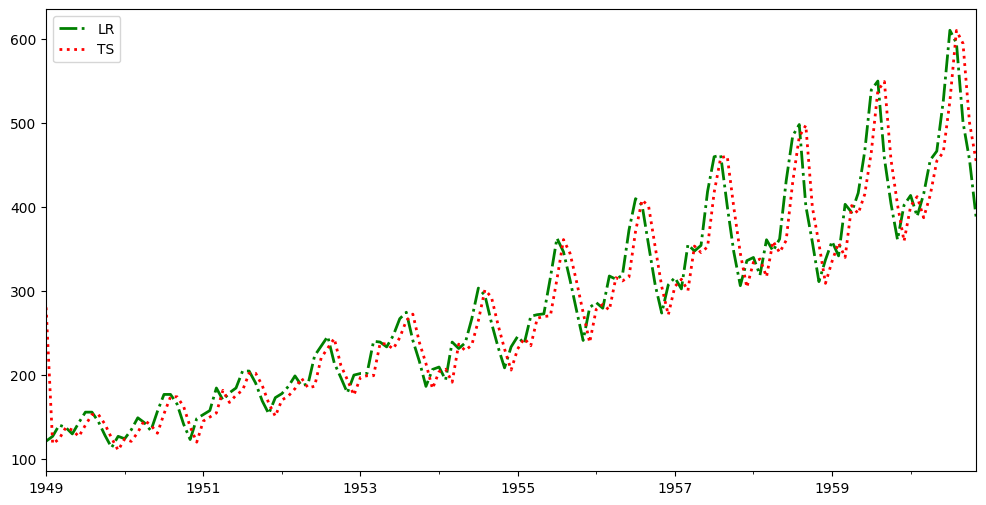

In [18]:
series2["TS"] = model.fittedvalues
series2["LR"] = lr2.coef_ * series["Passengers"] + lr2.intercept_
series2["LR"].plot(color="green", linestyle="-.", lw=2, legend="LR")
series2["TS"].plot(figsize=(12, 6), color="red", linestyle=":", lw=2, legend="TS")

In [19]:
series2[["TS", "LR"]]

,TS,LR
1949-01-01,280.294340,121.105886
1949-02-01,117.966280,126.859478
1949-03-01,123.753571,140.284526
1949-04-01,137.257251,137.407730
1949-05-01,134.363605,129.736274
...,...,...
1960-07-01,525.970313,610.161195
1960-08-01,609.886036,594.818283
1960-09-01,594.453259,500.842949
1960-10-01,499.927502,455.773147


## AR(1) 殘差(residual)繪圖

<Axes: >

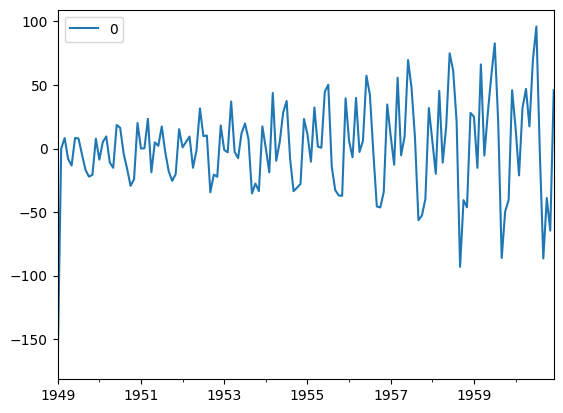

In [20]:
residuals = pd.DataFrame(model.resid)
residuals.plot()

## 資料分割

In [21]:
test_size = 12

from sklearn.model_selection import train_test_split

# 資料分割
X_train, X_test = train_test_split(series, test_size=test_size, shuffle=False)

# 查看陣列維度
X_train.shape, X_test.shape

((132, 1), (12, 1))

## 模型訓練、預測與繪圖

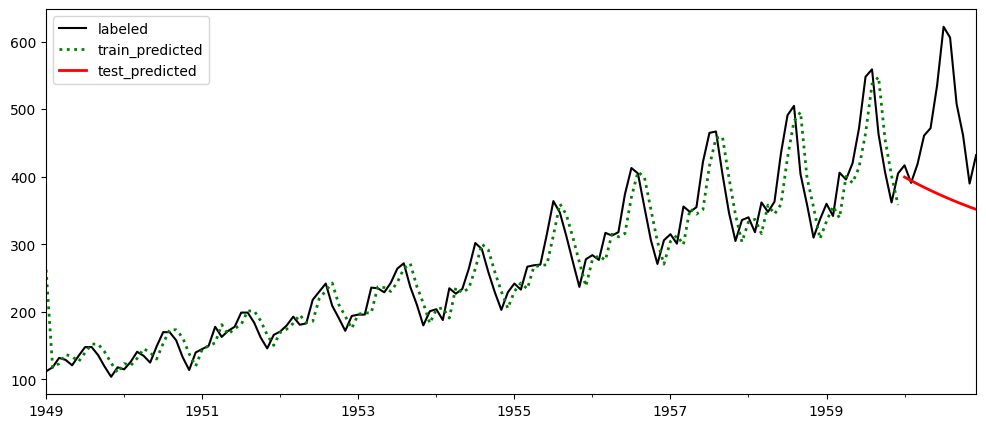

In [22]:
# AR(1) 模型訓練
ar_1 = ARIMA(X_train[["Passengers"]], order=(1, 0, 0))
model_1 = ar_1.fit()

# 預測 12 個月
pred = model_1.predict(X_train.shape[0], X_train.shape[0] + test_size - 1)

# 繪圖
series["Passengers"].plot(color="black", linestyle="-", label="labeled")
model_1.fittedvalues.plot(color="green", linestyle=":", lw=2, label="train_predicted")
pred.plot(figsize=(12, 5), color="red", lw=2, label="test_predicted")
plt.legend()

# 改用 SARIMAX (Seasonal ARIMA) 演算法

## 一次差分(First-order Differencing)

<Axes: >

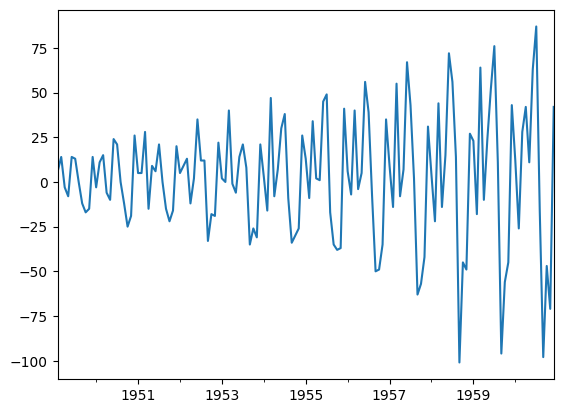

In [23]:
df_diff = df.copy()
df_diff["Passengers_diff"] = df_diff["Passengers"] - df_diff["Passengers"].shift(1)
df_diff.dropna(inplace=True)
df_diff["Passengers_diff"].plot()

## 使用ADF檢定

In [24]:
result = adfuller(df_diff["Passengers_diff"])
print(
    f"ADF統計量: {result[0]}\np value: {result[1]}"
    + f"\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}"
)

ADF統計量: -2.829266824169995
p value: 0.05421329028382612
滯後期數(Lags): 12
資料筆數: 130


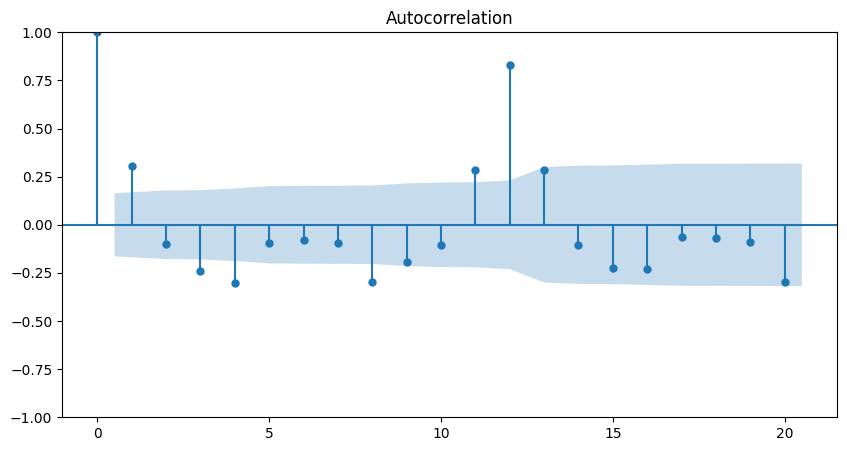

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(df_diff["Passengers_diff"], lags=20)
fig.set_size_inches(10, 5)

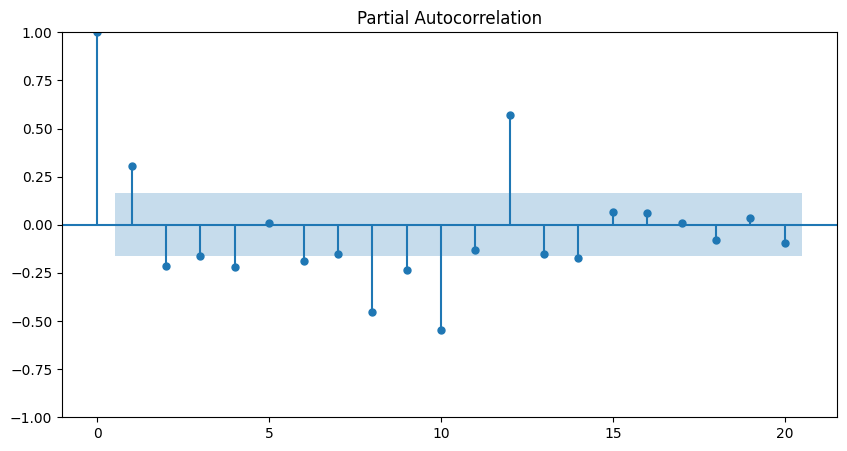

In [26]:
fig = plot_pacf(df_diff["Passengers_diff"], lags=20, method="ywm")
fig.set_size_inches(10, 5)

## 二次差分(Second-order Differencing)

<Axes: >

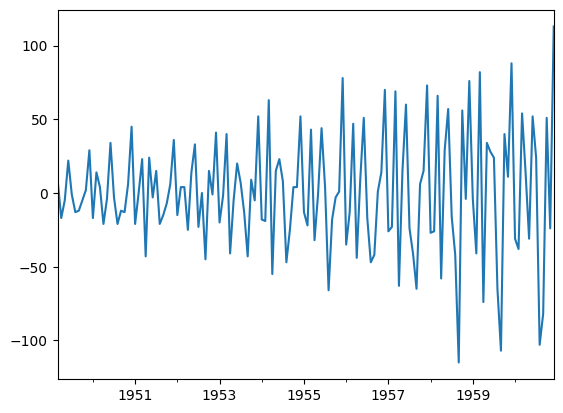

In [27]:
df_diff["Passengers_diff_2"] = df_diff["Passengers_diff"] - df_diff[
    "Passengers_diff"
].shift(1)
df_diff.dropna(inplace=True)

df_diff["Passengers_diff_2"].plot()

## 使用ADF檢定

In [28]:
result = adfuller(df_diff["Passengers_diff_2"])
print(
    f"ADF統計量: {result[0]}\np value: {result[1]}"
    + f"\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}"
)

ADF統計量: -16.384231542468463
p value: 2.732891850014476e-29
滯後期數(Lags): 11
資料筆數: 130


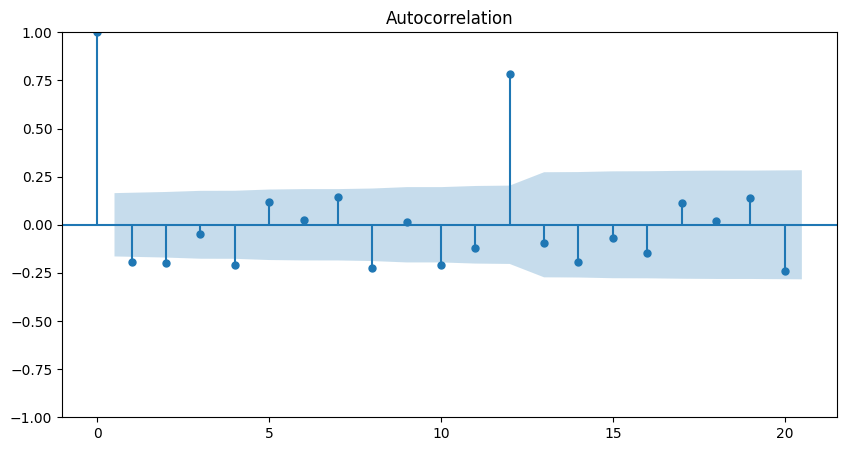

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(df_diff["Passengers_diff_2"], lags=20)
fig.set_size_inches(10, 5)

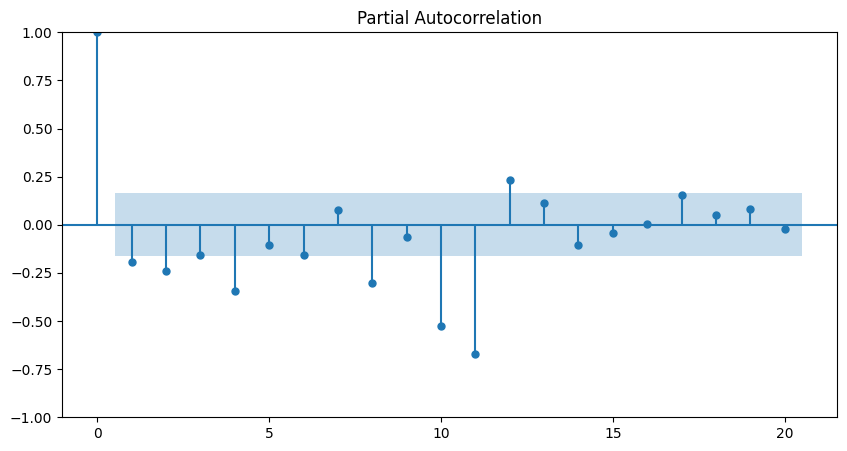

In [30]:
fig = plot_pacf(df_diff["Passengers_diff_2"], lags=20, method="ywm")
fig.set_size_inches(10, 5)

## SARIMAX

In [31]:
# 資料分割
X_train, X_test = train_test_split(df_diff, test_size=12, shuffle=False)

# SARIMAX
import statsmodels.api as sm

ar_diff = sm.tsa.statespace.SARIMAX(
    X_train[["Passengers"]], order=(1, 2, 1), seasonal_order=(1, 2, 1, 12)
)
model_diff = ar_diff.fit()

# 預測 12 個月
pred = model_diff.predict(X_train.shape[0], X_train.shape[0] + 12 - 1, dynamic=True)
pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29096D+00    |proj g|=  6.95498D-02


 This problem is unconstrained.



At iterate    5    f=  3.20817D+00    |proj g|=  4.45427D-02

At iterate   10    f=  3.08504D+00    |proj g|=  1.85141D-03

At iterate   15    f=  3.08441D+00    |proj g|=  9.95325D-04

At iterate   20    f=  3.08426D+00    |proj g|=  1.10097D-03

At iterate   25    f=  3.08421D+00    |proj g|=  9.41689D-04

At iterate   30    f=  3.08419D+00    |proj g|=  1.51273D-04

At iterate   35    f=  3.08418D+00    |proj g|=  3.28557D-04

At iterate   40    f=  3.08418D+00    |proj g|=  6.70086D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     47      1     0     0   6.701D-06   3.084D+00
  F =   3.08417968945

1960-01-01    421.641206
1960-02-01    400.104148
1960-03-01    464.769766
1960-04-01    453.272079
1960-05-01    479.173934
1960-06-01    542.544247
1960-07-01    620.968293
1960-08-01    634.765160
1960-09-01    526.393533
1960-10-01    469.198726
1960-11-01    419.473990
1960-12-01    461.469078
Freq: MS, Name: predicted_mean, dtype: float64

In [32]:
df_diff["pred"] = np.concatenate((model_diff.fittedvalues.values, pred.values))
df_diff["pred"]

1949-03-01      0.000000
1949-04-01    230.989622
1949-05-01    126.022665
1949-06-01    112.993414
1949-07-01    148.996769
                 ...    
1960-08-01    634.765160
1960-09-01    526.393533
1960-10-01    469.198726
1960-11-01    419.473990
1960-12-01    461.469078
Freq: MS, Name: pred, Length: 142, dtype: float64

## 繪圖

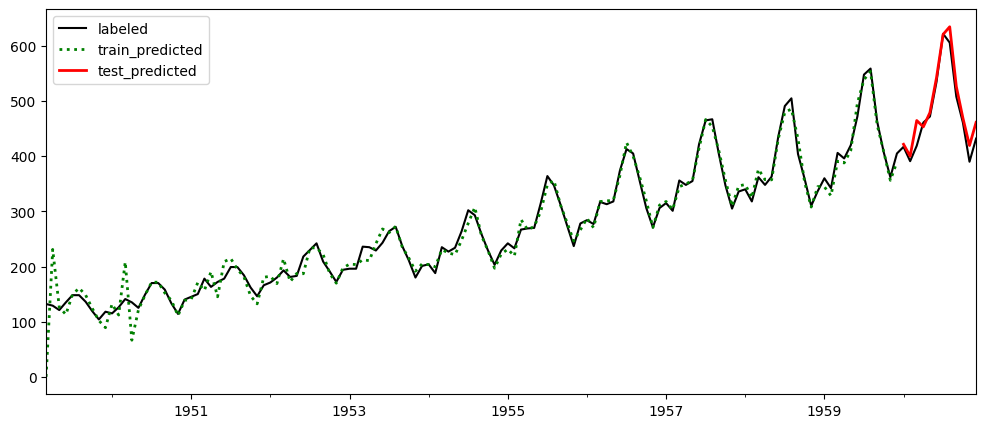

In [33]:
df_diff["Passengers"].plot(color="black", linestyle="-", label="labeled")
model_diff.fittedvalues.plot(color="green", linestyle=":", lw=2, label="train_predicted")
pred.plot(figsize=(12, 5), color="red", lw=2, label="test_predicted")
plt.legend()

In [34]:
print(f"SARIMAX MSE = {(np.sum(model_diff.resid**2) / len(model_diff.resid)):.2f}")

SARIMAX MSE = 427.67


## 結論：SARIMAX 準確率比迴歸高
### 時間序列 MSE： 427， 迴歸 MSE： 2091

<Axes: title={'center': 'Trend components'}>

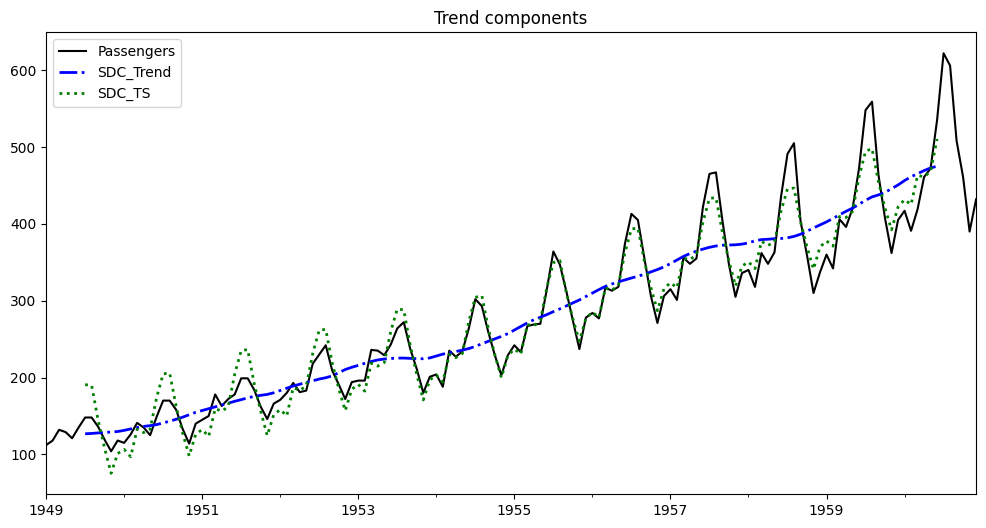

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = pd.read_csv("./data/monthly-airline-passengers.csv")
decomp["Date"] = pd.to_datetime(decomp["Month"])
decomp = decomp.set_index("Date")
decomp.index = pd.DatetimeIndex(df.index.values, freq=decomp.index.inferred_freq)
decomp.drop("Month", axis=1, inplace=True)

s_dc = seasonal_decompose(decomp["Passengers"], model="additive")
decomp["SDC_Seasonal"] = s_dc.seasonal
decomp["SDC_Trend"] = s_dc.trend
decomp["SDC_Error"] = s_dc.resid
decomp["SDC_TS"] = s_dc.trend + s_dc.seasonal


plt.title("Trend components")
decomp["Passengers"].plot(
    figsize=(12, 6), color="black", linestyle="-", legend="Passengers"
)
decomp["SDC_Trend"].plot(
    figsize=(12, 6), color="blue", linestyle="-.", lw=2, legend="SDC_Trend"
)
decomp["SDC_TS"].plot(figsize=(12, 6), color="green", linestyle=":", lw=2, legend="TS")

## 效應分解(Decomposition)

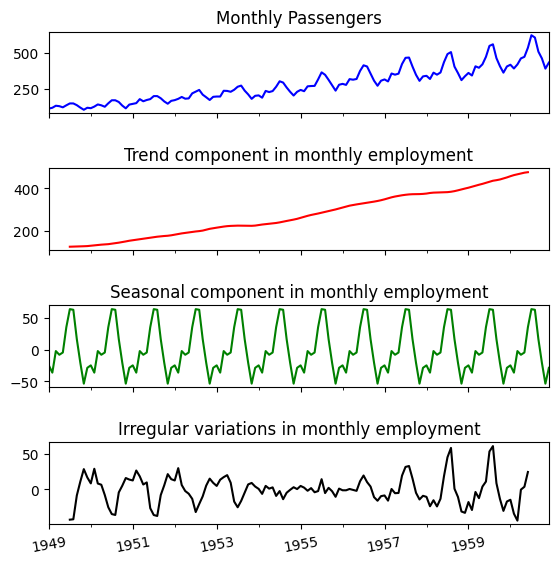

In [36]:
# Plot the original time series, trend, seasonal and random components
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(5.5, 5.5)

decomp["Passengers"].plot(ax=axarr[0], color="b", linestyle="-")
axarr[0].set_title("Monthly Passengers")

pd.Series(data=decomp["SDC_Trend"], index=decomp.index).plot(
    color="r", linestyle="-", ax=axarr[1]
)
axarr[1].set_title("Trend component in monthly employment")

pd.Series(data=decomp["SDC_Seasonal"], index=decomp.index).plot(
    color="g", linestyle="-", ax=axarr[2]
)
axarr[2].set_title("Seasonal component in monthly employment")

pd.Series(data=decomp["SDC_Error"], index=decomp.index).plot(
    color="k", linestyle="-", ax=axarr[3]
)
axarr[3].set_title("Irregular variations in monthly employment")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
fig = plt.xticks(rotation=10)


In [37]:
MSE = (decomp["SDC_Error"] ** 2).sum() / decomp["SDC_Error"].shape[0]
"MSE=", MSE

('MSE=', 340.80467800107556)

## 結論：時間序列預測準確率比迴歸高
### 時間序列 MSE： 340， 迴歸 MSE： 2091